In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

In [2]:
hashtag = 'babies'
df = pd.read_json(f'json_files/{hashtag}.json')
df.head()

,hashtags,image,image_local_name,post_link,search_hashtag
0,"[#littlefloofs, #babyberners, #breeders, #bern...",https://scontent-lga3-1.cdninstagram.com/vp/00...,555cc3a1-bfa6-4920-8799-b7da7779f843.jpg,https://www.instagram.com/p/By5MyabBYa1/,babies
1,"[#kenya, #haiafrica, #africa, #babies]",https://scontent-lga3-1.cdninstagram.com/vp/ba...,376d45c7-2a68-4f0d-9b4f-2436d396b35f.jpg,https://www.instagram.com/p/By5QF5SH0Hm/,babies
2,"[#beautiful, #cuteness, #baby, #somuchlove, #n...",https://scontent-lga3-1.cdninstagram.com/vp/e7...,de7182d8-407e-4701-825e-2934a4c61521.jpg,https://www.instagram.com/p/By45FlyiROZ/,babies
3,[#sponsered],https://scontent-lga3-1.cdninstagram.com/vp/24...,f858ab6f-f036-4e4f-93be-5ee82f5bd1ff.jpg,https://www.instagram.com/p/By4-rg9ncXC/,babies
4,[],https://scontent-lga3-1.cdninstagram.com/vp/97...,1ea61d45-b7a3-439d-8ac2-4a9c4c3374f5.jpg,https://www.instagram.com/p/By49zYTFUyx/,babies


In [3]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [4]:
pics = []
for i, row in df.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    img = prepare_image(img_path)
    pics.append({'pic': img, 'hashtag': hashtag})

In [5]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0619 15:45:49.565040 4539409856 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


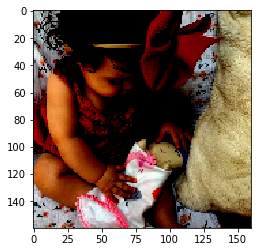

In [6]:
plt.imshow(pics[64]['pic']);

In [7]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [8]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [9]:
deep_features = list(map(extract_features, pics))

In [10]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [12]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'deep_features'])